In [1]:
import os, itertools
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

import jax
jax.config.update('jax_platform_name', 'cpu')
    
from smolyax import indices, nodes
from smolyax.interpolation import SmolyakBarycentricInterpolator

We consider the high-dimensional test target function $f : [-1,1]^d \to \mathbb{R}$ already introduced in `smolyak_example_high_D.ipynb` and  given by
$$ f(\boldsymbol{x}) = \frac{1}{1 + \Theta \sum_{j=1}^d (j+1)^{-r} x_j} $$
for some $\Theta \in (0,1)$ and $r\ge1$.

In [2]:
def target_f(x, theta, r) :
    return 1/(1+ theta * np.sum(x * (np.arange(x.shape[-1]) + 2)**(-r), axis=-1))

We test the convergence of the Smolyak quadrature implemented by `SmolyakBarycentricInterpolator.integral()`.
Given a target function $f$, this method computes the integral of its Smolyak interpolant $I^\Lambda[f]$, which is equivalent to the Smolyak quadrature approximation $Q^\Lambda[f]$ of the integral of the target function $f$, i.e.,
$$
Q^\Lambda [f] = \int_{[-1,1]^d} I^\Lambda [f] {\rm d} x \quad \approx \quad  \int_{[-1,1]^d} f(x) {\rm d} x.
$$

Below, we demonstrate convergence of the integral as the number of interpolation nodes $n = |\Lambda|$ increases. Further, we verify that a Monte-Carlo estimate of integral of the interpolant, i.e. the estimator
$$
Q_{\rm MC}^\Lambda [f] = \sum_{j=1}^N I^\Lambda [f] (x_j) \quad \approx \quad Q^\Lambda[f]
$$
for $N$ random samples $(x_j)_{j=1}^d \subset [-1,1]^d$, converges to $Q^\Lambda[f]$.

### Convergence of $Q^\Lambda [f]$ as $|\Lambda| \to \infty$

In [3]:
d, r, theta = 100, 2., .1
f = lambda x : target_f(x, theta, r)
node_gen = nodes.GaussHermite(dim=d)
k = [np.log((ki+2)**(r)/theta) for ki in range(d)]
max_t = indices.find_approximate_threshold(k, 1000, node_gen.is_nested)
ips = [SmolyakBarycentricInterpolator(node_gen=node_gen, k=k, t=t, d_out=1, f=f) for t in np.linspace(1,max_t,10)]
err = np.zeros((len(ips)-1,))
qf = ips[-1].integral()[0]
for i, ip in enumerate(ips[:-1]) :
    err[i] = np.abs(ip.integral()[0] - qf)

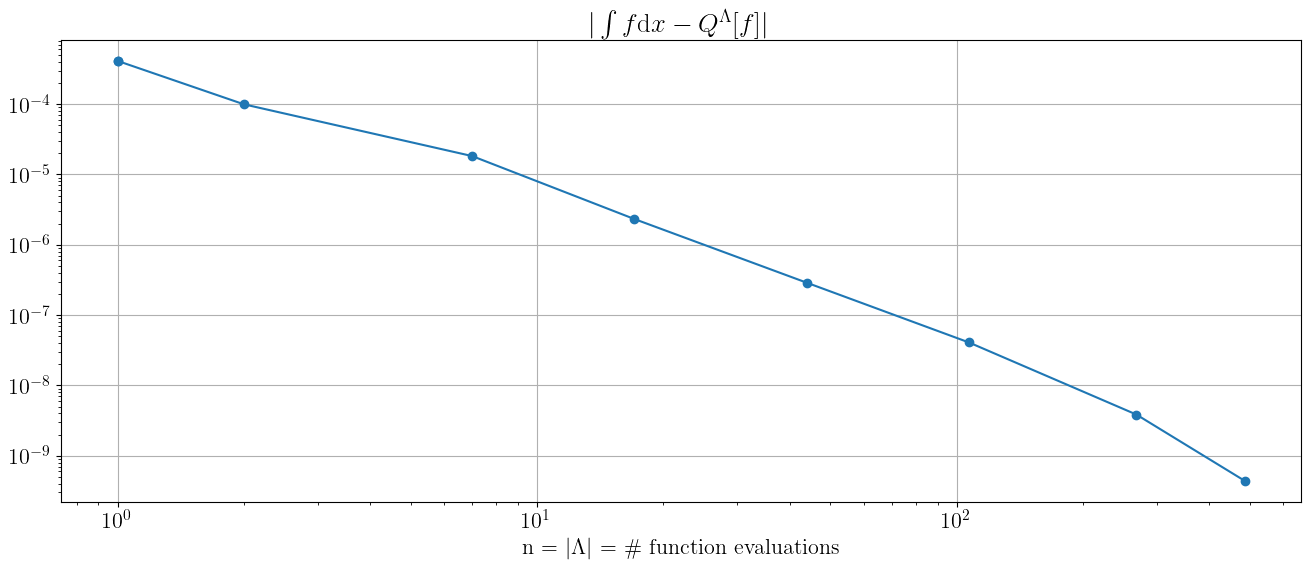

In [4]:
ax = plt.figure(figsize=(16, 6)).add_subplot(111)
ax.loglog([s.n_f_evals for s in ips[:-1]], err, marker='o')
ax.set_xlabel(r'n = $|\Lambda|$ = \# function evaluations'); ax.set_title(r'$|\int f {\rm d}x - Q^\Lambda[f]|$'); ax.grid();

### Convergence of $Q_{MC}^\Lambda [f]$ to $Q^\Lambda [f]$

In [5]:
ns = [100,200,400,800, 1600, 3200, 6400, 12000, 24000, 50_000, 100_000, 200_000, 400_000]
err_mc = np.zeros((len(ns),))
ip = ips[-2]
qf = np.squeeze(ip.integral())
for i, n in enumerate(ns) :
    err_mc[i] = np.abs(np.mean(ip(node_gen.get_random(n))) - qf) / qf

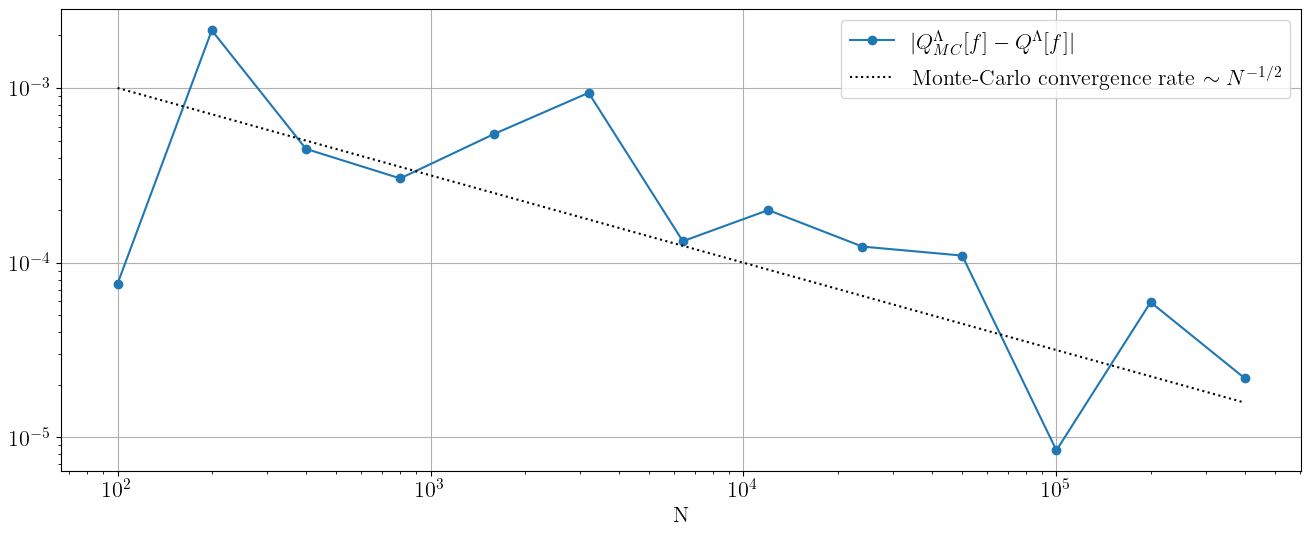

In [6]:
ax = plt.figure(figsize=(16, 6)).add_subplot(111)
ax.loglog(ns, err_mc, marker='o', label=r'$|Q_{MC}^\Lambda [f] - Q^\Lambda [f]|$')
ax.loglog(ns, 1e-2 * np.array(ns)**(-.5), 'k:', label=r'Monte-Carlo convergence rate $\sim N^{-1/2}$')
ax.set_xlabel(r'N'); ax.grid(); ax.legend();